<a href="https://colab.research.google.com/github/jhlee93/Baseline/blob/main/ImageClassification/augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# 데이터세트 다운로드
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

228827136/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


In [3]:
print(os.listdir(data_dir))
image_count = len(list(data_dir.glob('*/*.jpg')))
print('image count: ', image_count)

['dandelion', 'tulips', 'roses', 'sunflowers', 'LICENSE.txt', 'daisy']
image count:  3670


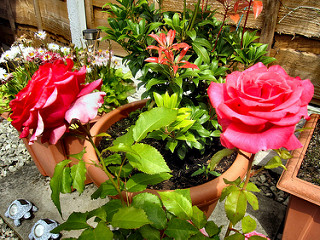

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# keras preprocessing을 사용하여 데이터 로드

In [5]:
# 데이터 로드를 위해 매개변수 정의
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# tf.keras.preprocessing.image_dataset_from_directory API를 활용하여 폴더별로 구분된 클래스들을 알아서 불러옴
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # 클래스별로 구분된 상위 디렉토리 경로
    validation_split=0.2, # 검증셋 20% 분할
    subset='training', # 학습 데이터셋
    seed=123, # 재현성 검증을 위해 무작위성 고정
    image_size=(img_height, img_width), # 이미지 shape을 아래와 같이 변형시켜 가져옴
    batch_size=batch_size # 학습 배치사이즈 지정
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
# image_dataset_from_directory를 통해 로드된 데이터셋은 아래와 같이 확인 가능
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# 데이터 확인

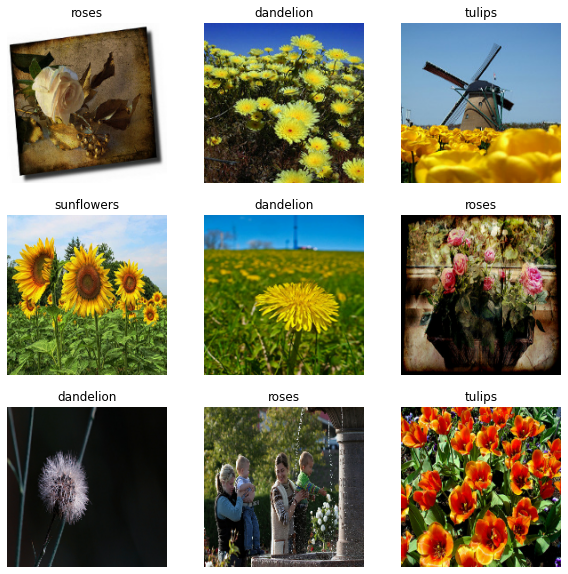

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')


In [10]:
# image_dataset_from_directory 를 통해 로드된 데이터셋이 어떤 식으로 가져오는지 확인
# 사전에 배치사이즈, 이미지 크기를 설정했기 때문에 정의된 배치 사이즈만큼 이미지와 정답을 가져옴
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


Dataset.cache()는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

Dataset.prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 데이터 정규화

In [12]:
# 이미지 픽셀값을 0~1 사이값으로 정규화/표준화하여 학습이 진행되도록 모델을 구성
num_classes = len(class_names)
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(), # 기본값 pool_size=(2,2)를 사용 
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [13]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
92/92 [==============================] - 23s 63ms/step - loss: 1.3836 - accuracy: 0.3995 - val_loss: 1.1471 - val_accuracy: 0.5395
Epoch 2/100
92/92 [==============================] - 4s 42ms/step - loss: 1.0290 - accuracy: 0.5851 - val_loss: 0.9632 - val_accuracy: 0.6090
Epoch 3/100
92/92 [==============================] - 4s 42ms/step - loss: 0.8063 - accuracy: 0.6846 - val_loss: 0.9503 - val_accuracy: 0.6294
Epoch 4/100
92/92 [==============================] - 4s 44ms/step - loss: 0.5925 - accuracy: 0.7776 - val_loss: 0.9672 - val_accuracy: 0.6621
Epoch 5/100
92/92 [==============================] - 4s 42ms/step - loss: 0.3669 - accuracy: 0.8689 - val_loss: 1.1745 - val_accuracy: 0.6253
Epoch 6/100
92/92 [==============================] - 4s 42ms/step - loss: 0.2427 - accuracy: 0.9183 - val_loss: 1.2855 - val_accuracy: 0.6117
Epoch 7/100
92/92 [==============================] - 4s 42ms/step - loss: 0.1039 - accuracy: 0.9693 - val_loss: 1.4805 - val_accuracy: 0.6090
Epoch

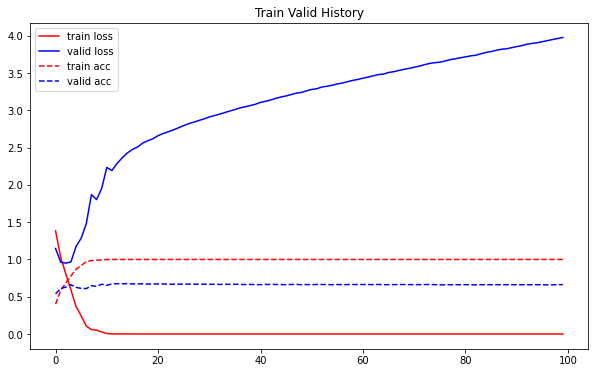

In [15]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(range(epochs), train_loss, label='train loss', c='r')
plt.plot(range(epochs), valid_loss, label='valid loss', c='b')
plt.plot(range(epochs), train_acc, '--', label='train acc', c='r')
plt.plot(range(epochs), valid_acc, '--', label='valid acc', c='b')
plt.title('Train Valid History')
plt.legend()
plt.show()

# 데이터 증강

In [16]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

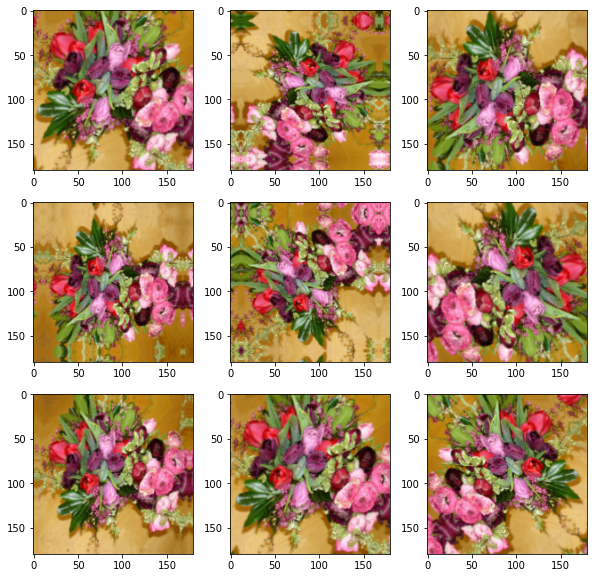

In [17]:
# 증강된 데이터 시각화하기
for images, labels in train_ds.take(1):
    tf_sample_image = images[0:1] # 1 batch

    plt.figure(figsize=(10,10))
    for i in range(9):
        augmented_image = data_augmentation(tf_sample_image)
        ax = plt.subplot(3,3,i+1)
        ax.imshow(augmented_image[0].numpy().astype(np.uint8))

In [18]:
model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
# 모델 컴파일
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs=100
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
92/92 [==============================] - 6s 51ms/step - loss: 1.3314 - accuracy: 0.4091 - val_loss: 1.1211 - val_accuracy: 0.5082
Epoch 2/100
92/92 [==============================] - 4s 49ms/step - loss: 1.0960 - accuracy: 0.5473 - val_loss: 1.2449 - val_accuracy: 0.4986
Epoch 3/100
92/92 [==============================] - 4s 49ms/step - loss: 1.0128 - accuracy: 0.5913 - val_loss: 1.0114 - val_accuracy: 0.5913
Epoch 4/100
92/92 [==============================] - 4s 49ms/step - loss: 0.9512 - accuracy: 0.6196 - val_loss: 0.9283 - val_accuracy: 0.6267
Epoch 5/100
92/92 [==============================] - 4s 49ms/step - loss: 0.8935 - accuracy: 0.6410 - val_loss: 0.8705 - val_accuracy: 0.6499
Epoch 6/100
92/92 [==============================] - 4s 49ms/step - loss: 0.8439 - accuracy: 0.6703 - val_loss: 0.8287 - val_accuracy: 0.6771
Epoch 7/100
92/92 [==============================] - 5s 49ms/step - loss: 0.8302 - accuracy: 0.6649 - val_loss: 0.8951 - val_accuracy: 0.6526
Epoch 

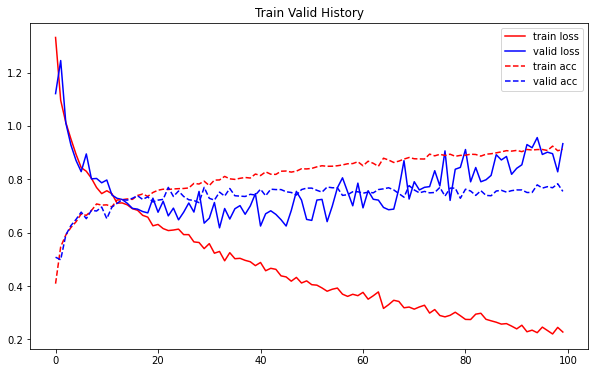

In [21]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(range(epochs), train_loss, label='train loss', c='r')
plt.plot(range(epochs), valid_loss, label='valid loss', c='b')
plt.plot(range(epochs), train_acc, '--', label='train acc', c='r')
plt.plot(range(epochs), valid_acc, '--', label='valid acc', c='b')
plt.title('Train Valid History')
plt.legend()
plt.show()

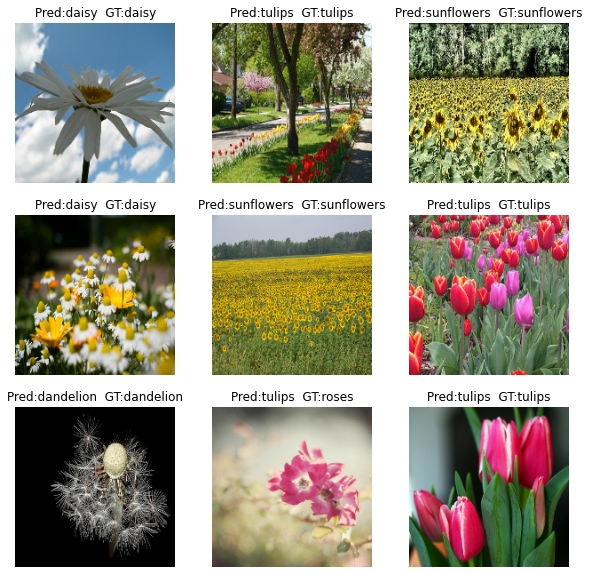

In [52]:
# 검증 데이터 결과 확인
for val_images, val_labels in val_ds.take(1):
    preds = model2.predict(val_images)
    pred_labels = np.argmax(preds, axis=1) # 32개(배치)에 대한 예측 레이블 인덱스
    pred_names = [class_names[x] for x in pred_labels] # 예측 레이블 이름

    # 정답 레이블
    gt_labels = val_labels.numpy()
    gt_names = [class_names[x] for x in gt_labels]

    # 9개만 확인
    plt.figure(figsize=(10,10))

    for i, val_image in enumerate(val_images[:9]):
        val_image = (val_image.numpy()).astype(np.uint8)
        # plt.imshow(val_image)
        ax=plt.subplot(3,3,i+1)
        ax.imshow(val_image)
        ax.set_title(f'Pred:{pred_names[i]}  GT:{gt_names[i]}')
        ax.set_axis_off()
    plt.show()

In [72]:
# validation data를 평가 데이터로 가정하고 평가
pred_arr, answer_arr = [], []
for val_images, val_labels in val_ds:
    batch_pred = model2.predict(val_images)
    batch_pred_labels = list(np.argmax(batch_pred, axis=1))
    batch_gt_labels = list(val_labels.numpy())

    pred_arr.extend(batch_pred_labels)
    answer_arr.extend(batch_gt_labels)

pred_arr = np.array(pred_arr)
answer_arr = np.array(answer_arr)
print('pred arr shape: ', pred_arr.shape)
print('answer arr shape: ', answer_arr.shape)
print()
pred_arr = pred_arr[:734]
print('pred arr shape: ', pred_arr.shape)
print('answer arr shape: ', answer_arr.shape)

from sklearn.metrics import accuracy_score
acc = accuracy_score(answer_arr, pred_arr)
print()
print(acc)
print(np.sum(answer_arr==pred_arr) / len(answer_arr))

pred arr shape:  (734,)
answer arr shape:  (734,)

pred arr shape:  (734,)
answer arr shape:  (734,)

0.7547683923705722
0.7547683923705722


0.22343324250681199
